In [37]:
import pandas as pd
import numpy as np
import os.path
from os import path
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
if path.exists("/kaggle/input/apache-hadoop-ozone-contributions"):
   os.chdir("/kaggle/input/apache-hadoop-ozone-contributions")


In [20]:
contributions = pd.read_csv("github-contribution.csv.gz")
contributions.date = pd.to_datetime(contributions.date * 1000000, utc = True)

Latest record from the dataset:

In [21]:
contributions.sort_values("date", ascending=False).head(1)
# contributions = contributions[contributions.date > '2020-06-01']

         org   repo          type  identifier  subidentifier  \
7843  apache  ozone  PR_COMMENTED        1766            NaN   

                          date          author           owner  
7843 2021-02-11 04:27:15+00:00  bharatviswa504  bharatviswa504  

# Github Contributions per user


In [22]:
c = contributions[["identifier","author","type","owner"]].groupby(["author","type","owner"]).count() \
   .reset_index().rename(columns={"identifier":"contributions"})
#contributions per user
c[c.author != c.owner][["author","contributions"]].groupby("author").sum().sort_values("contributions",ascending=False).head(10)


                  contributions
author                         
bharatviswa504             1179
adoroszlai                 1149
xiaoyuyao                  1079
elek                        932
bshashikant                 354
avijayanhwx                 337
dineshchitlangia            330
arp7                        273
anuengineer                 257
linyiqun                    246

## Contributors per participations in PRs which are not created by self (helping PRs)

In [23]:
c = contributions[contributions.author != contributions.owner][["identifier","author"]].groupby(["identifier","author"]).count() \
   .reset_index().groupby("author").count()
c.sort_values("identifier",ascending=False).head(20)

                   identifier
author                       
adoroszlai                509
elek                      413
bharatviswa504            295
xiaoyuyao                 292
dineshchitlangia          146
avijayanhwx               143
bshashikant               140
arp7                      126
anuengineer               121
vivekratnavel             100
mukul1987                  97
ChenSammi                  92
github-actions             85
codecov-commenter          76
nandakumar131              76
linyiqun                   71
amaliujia                  67
hanishakoneru              62
lokeshj1703                59
swagle                     56

## Contributors per participations in any PRs

In [24]:
c = contributions[["identifier","author"]].groupby(["identifier","author"]).count() \
   .reset_index().groupby("author").count()
c.sort_values("identifier",ascending=False).head(20)

                  identifier
author                      
adoroszlai               782
elek                     596
bharatviswa504           427
xiaoyuyao                329
avijayanhwx              220
bshashikant              190
dineshchitlangia         164
vivekratnavel            154
mukul1987                139
ChenSammi                128
arp7                     128
anuengineer              123
hanishakoneru            110
amaliujia                102
nandakumar131             98
maobaolong                96
swagle                    89
smengcl                   86
github-actions            85
GlenGeng                  84

# Bus factor (number of contributors responsible for the 50% of the prs)

## Contributors until the half of the all contributions

In [25]:
prcreated = contributions[contributions.type == "PR_CREATED"]
prcreated = prcreated[["identifier"]].groupby(prcreated.author).count().reset_index()
prcreated = prcreated.sort_values("identifier", ascending=False)
prcreated = prcreated.reset_index(drop=True)
prcreated["cs"] = prcreated["identifier"].cumsum()
prcreated["ratio"]= prcreated.identifier / prcreated.identifier.sum()  * 100
prcreated[prcreated.cs < prcreated.identifier.sum() / 2]

           author  identifier   cs      ratio
0      adoroszlai         275  275  14.211886
1            elek         190  465   9.819121
2  bharatviswa504         132  597   6.821705
3     avijayanhwx          77  674   3.979328
4      maobaolong          68  742   3.514212
5         smengcl          60  802   3.100775
6   vivekratnavel          54  856   2.790698
7     bshashikant          50  906   2.583979
8      runzhiwang          49  955   2.532300

## Pony number (bus factor)

In [26]:
pn = (prcreated[prcreated.cs < prcreated.identifier.sum() / 2]).shape[0] + 1
pn

10

## Dev power (All the contributions in the ration of the top contributor)

In [27]:
prcreated["power"] = prcreated["identifier"] / prcreated.reset_index()["identifier"][0] 
prcreated.power.sum()

7.036363636363638

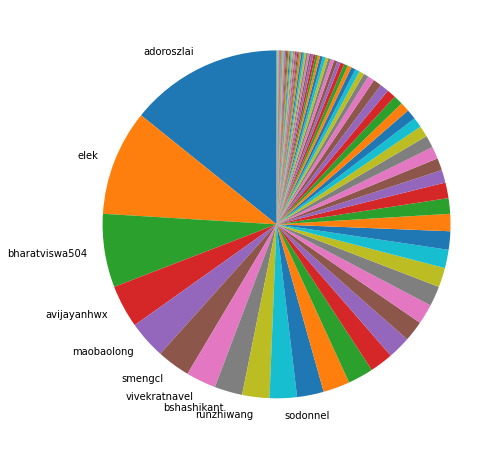

In [28]:
labels = np.asarray(prcreated["author"])
for i in range(pn,len(labels)):
    labels[i] = ""
plt.figure(figsize=(10,8))
plt.pie(prcreated["ratio"], labels=labels, startangle=90)
plt.show()


## People with created PRs > reviewed/commented PRS

In [29]:
created = contributions[contributions.type == "PR_CREATED"][["author","identifier"]].groupby("author").count().rename(columns={"identifier":"created"})
helped = contributions[contributions.author != contributions.owner][["identifier"]].groupby([contributions.author,contributions.identifier]).sum().rename(columns={"identifier":"helped"}) \
  .reset_index().groupby(["author"]).count().drop(columns=["identifier"])
merged = pd.merge(helped,created, left_index=True, right_index=True)

gh = pd.read_csv("ozone_github_memberhsip.csv")
merged.index = merged.index.rename("githubname")
merged = merged.join(gh.set_index("githubname")).reset_index()
merged.role = merged.role.fillna("?")
merged["rc"] = merged.role.map({"pmc":"red","committer":"yellow","?":"blue"})


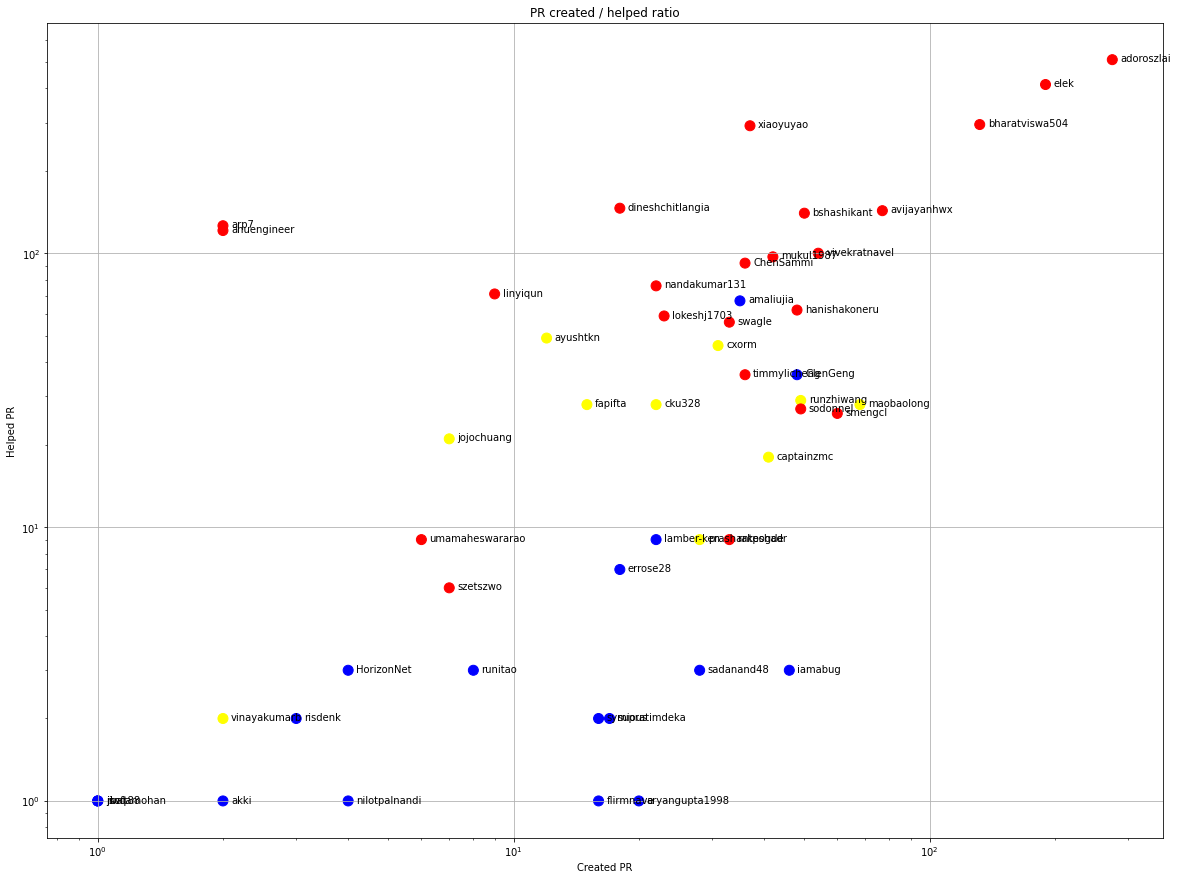

In [30]:
source = merged.reset_index()

plt.figure(figsize=(20,15))

plt.scatter(source.created,source.helped,color=source.rc, s= 100)

plt.xlabel('Created PR')
plt.ylabel('Helped PR')
plt.title('PR created / helped ratio')
plt.grid()

for index, row in source.iterrows():
     plt.annotate(row["githubname"], (row["created"], row["helped"]), xytext=(8,-2), textcoords='offset points')
plt.semilogx()
plt.semilogy()
plt.show()

# Number of individual contributors per month

Number of different Github users who either created PR, commented PR, added review to a PR

Note: only events from apache/hadoop-ozone repository are included. Earlier PRs/comments are not here.

In [31]:
m = contributions[["identifier"]].groupby([contributions.date.dt.to_period("M"),contributions.author]).count() \
  .reset_index()
result = m[["author"]].groupby([m.date]).count().sort_values("date").reset_index()

/usr/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [32]:
result.tail(12)

       date  author
8   2020-03      37
9   2020-04      40
10  2020-05      44
11  2020-06      48
12  2020-07      46
13  2020-08      39
14  2020-09      45
15  2020-10      40
16  2020-11      47
17  2020-12      42
18  2021-01      47
19  2021-02      35

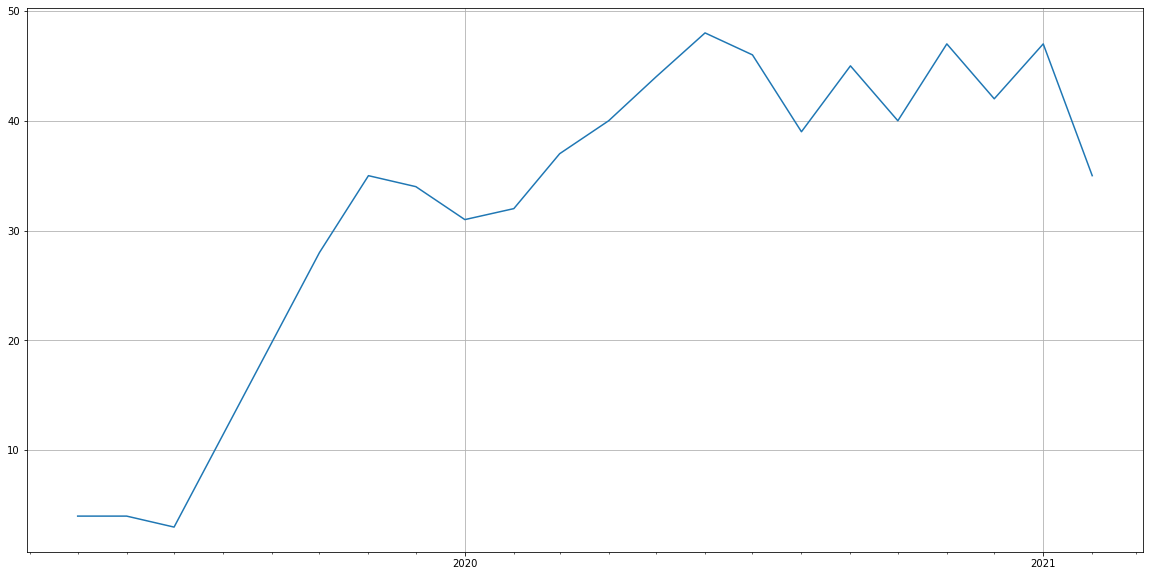

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


result['d'] = result['date'].apply(pd.Period.to_timestamp)
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot('d', 'author', data=result)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

ax.grid(True)

plt.show()

# Number of PRs closed/created per month

In [34]:
a = contributions[contributions.type.isin(["PR_CREATED","PR_MERGED"])]
a = a[["identifier"]].groupby([a.date.dt.to_period("M"),a.type]).count().reset_index()
a = a.pivot(index="date",columns="type",values="identifier")
a.sort_values("date",ascending=False).head(10)
a.columns = ["created","merged"]
a = a.reset_index()

/usr/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


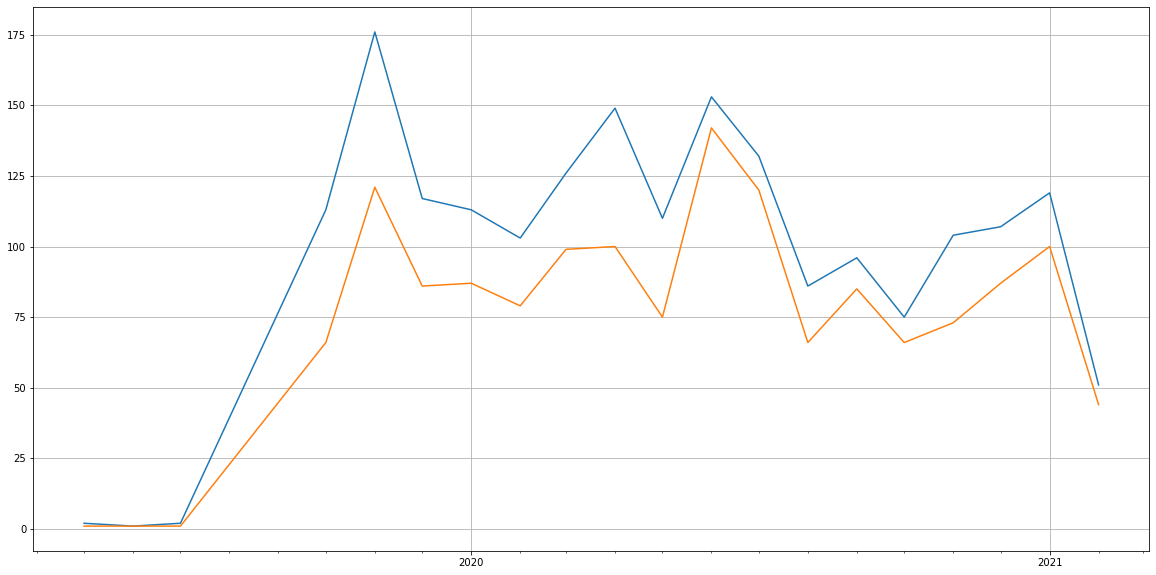

In [35]:
a['d'] = a['date'].apply(pd.Period.to_timestamp)
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot('d', 'created', data=a)
ax.plot('d', 'merged', data=a)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

ax.grid(True)

plt.show()

## Monthly comments

In [36]:
contributions[contributions.type == "PR_COMMENTED"][["identifier"]].groupby([contributions.date.dt.to_period("M")]).count()

/usr/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


         identifier
date               
2019-05           4
2019-06          14
2019-07           1
2019-10         250
2019-11         383
2019-12         320
2020-01         281
2020-02         225
2020-03         403
2020-04         442
2020-05         400
2020-06         562
2020-07         411
2020-08         306
2020-09         330
2020-10         200
2020-11         298
2020-12         315
2021-01         355
2021-02         198